In [1]:
from src.pipeline import build_pipeline

departure = 'LEMD'
destinations = [
  'LEAS',
  'LEBB',
  'LEBL',
  'LECO',
  'LEGR',
  'LEJR'
]

flights_path = 'data/flights'
flights_points_path = 'data/flight_points'

data_pipeline = build_pipeline(flights_path = flights_path, 
                               flights_points_path = flights_points_path, 
                               departure = departure, 
                               destinations = destinations)

trajectories_result, sspd_calculator, erp_calculator = data_pipeline.transform(None)

trajectories = trajectories_result['trajectories']
sspd_distances = sspd_calculator['sspd_distances']
erp_distances = erp_calculator['erp_distances']

## SSPD distances

### DBSCAN

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: [Sander et al. 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.1629&rep=rep1&type=pdf) and [Schubert et al. 2017](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) (both papers from the original DBSCAN authors).

(1680.0, 1730.0, 0.0, 0.02)

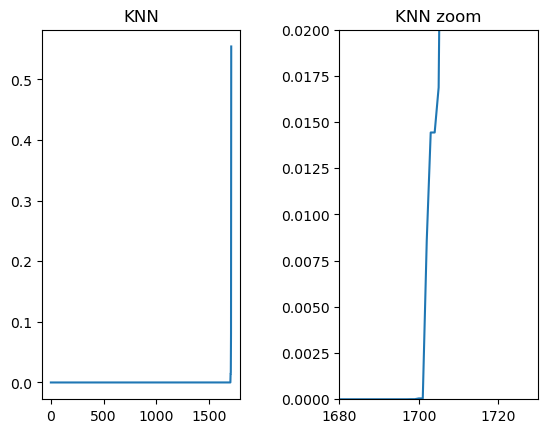

In [2]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(sspd_distances)
distances, indices = neighbors_fit.kneighbors(sspd_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([1680, 1730, 0, 0.02])

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd
from itertools import product
import numpy as np

results = []
eps_values = np.arange(0.006, 0.021, 0.001)
min_samples_values = np.arange(3, 16)
for eps, min_samples in product(eps_values, min_samples_values):
  # Ajusta el modelo HDBSCAN utilizando la matriz de distancias
  clusterer = DBSCAN(metric='precomputed', min_samples=min_samples, eps=eps)
  clusterer.fit(sspd_distances)

  # Obtiene las etiquetas de los clusters para cada trayectoria
  labels = clusterer.labels_
  results.append([eps, min_samples, labels])

table = []
for eps, min_samples, labels in results:
  n_outliers = np.sum(labels == -1)
  table.append({
    "min_samples": min_samples,
    "eps": eps,
    "clusters": len(set(labels)),
    "outliers": n_outliers,
    "noise": 100 * n_outliers / len(labels),
    "silhouette": silhouette_score(sspd_distances, labels)
  })

print(pd.DataFrame(table).sort_values(by='silhouette', ascending=False).head(20))

    min_samples    eps  clusters  outliers     noise  silhouette
65            3  0.011        20        13  0.760234    0.983304
52            3  0.010        20        13  0.760234    0.983304
39            3  0.009        20        13  0.760234    0.983304
0             3  0.006        20        14  0.818713    0.982918
13            3  0.007        20        14  0.818713    0.982918
26            3  0.008        20        14  0.818713    0.982918
66            4  0.011        19        16  0.935673    0.979827
53            4  0.010        19        16  0.935673    0.979827
40            4  0.009        19        16  0.935673    0.979827
27            4  0.008        19        17  0.994152    0.979473
14            4  0.007        19        17  0.994152    0.979473
1             4  0.006        19        17  0.994152    0.979473
67            5  0.011        17        24  1.403509    0.971132
54            5  0.010        17        24  1.403509    0.971132
41            5  0.009   

In [50]:
from sklearn.cluster import DBSCAN
import folium

# Run the grid search
clusterer = DBSCAN(metric='precomputed', min_samples=3, eps=0.01)
clusterer.fit(sspd_distances)
labels = clusterer.labels_

m = folium.Map(location=trajectories[0][0], zoom_start=3, tiles='cartodbpositron', zoom_control=False)

# Add the trajectories to the map
for i, trajectory in enumerate(trajectories):
    # Choose a color based on whether the trajectory is anomalous
    color = 'red' if labels[i] == -1 else 'blue'
    # Set the line weight and opacity
    weight = 2 if labels[i] == -1 else 1
    opacity = 1 if labels[i] == -1 else 1
    folium.PolyLine(trajectory, color=color, weight=weight, opacity=opacity).add_to(m)

# Display the maps
m

### HDBSCAN

In [108]:
from sklearn.metrics import silhouette_score
import hdbscan

"""
Lo ideal es obtener el mayor coef. de silueta con el menor ruido posible. 
Segun Andrew Churchill and Michael Bloem, Hierarchical clustering of aircraft 
surface trajectories, AIAA AVIATION 2020 FORUM., los niveles de ruido no 
deberían superar el 20% y como mínimo, el nivel coef de silueta no debería bajar
de 50%
"""

erp_results = []
min_samples_values = np.arange(1, 16)
min_cluster_size_values = [2, 5, 10, 20, 40, 60, 80, 100, 120, 140]
for min_samples, min_cluster_size in product(min_samples_values, min_cluster_size_values):
  # Ajusta el modelo HDBSCAN utilizando la matriz de distancias
  clusterer = hdbscan.HDBSCAN(metric='precomputed', min_samples=min_samples, min_cluster_size = min_cluster_size)
  clusterer.fit(sspd_distances)

  # Obtiene las etiquetas de los clusters para cada trayectoria
  labels = clusterer.labels_
  erp_results.append([min_samples, min_cluster_size, labels])

table = []
for min_samples, min_cluster_size, labels in erp_results:
  n_outliers = np.sum(labels == -1)
  table.append({
    "min_samples": min_samples,
    "min_clusters_size": min_cluster_size,
    "clusters": len(set(labels)),
    "outliers": n_outliers,
    "noise": 100 * n_outliers / len(labels),
    "silhouette": silhouette_score(sspd_distances, labels)
  })

print(pd.DataFrame(table).sort_values(by='silhouette', ascending=False).head(20))

     min_samples  min_clusters_size  clusters  outliers     noise  silhouette
30             4                  2        27         9  0.526316    0.986852
0              1                  2        31         5  0.292398    0.986448
31             4                  5        22        10  0.584795    0.985525
1              1                  5        22        10  0.584795    0.985525
11             2                  5        22        10  0.584795    0.985525
21             3                  5        22        10  0.584795    0.985525
20             3                  2        28         9  0.526316    0.983606
10             2                  2        27        13  0.760234    0.979972
66             7                 80         9         7  0.409357    0.964545
36             4                 80         9         7  0.409357    0.964545
116           12                 80         9         7  0.409357    0.964545
126           13                 80         9         7  0.40935

In [109]:
import hdbscan
import folium

# Run the grid search
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_samples=4, min_cluster_size = 2)
clusterer.fit(sspd_distances)
labels = clusterer.labels_

m = folium.Map(location=trajectories[0][0], zoom_start=3, tiles='cartodbpositron', zoom_control=False)

# Add the trajectories to the map
for i, trajectory in enumerate(trajectories):
    # Choose a color based on whether the trajectory is anomalous
    color = 'red' if labels[i] == -1 else 'blue'
    # Set the line weight and opacity
    weight = 2 if labels[i] == -1 else 1
    opacity = 1 if labels[i] == -1 else 1
    folium.PolyLine(trajectory, color=color, weight=weight, opacity=opacity).add_to(m)

# Display the maps
m

## ERP Distances

### DBSCAN

(1680.0, 1715.0, 0.0, 0.2)

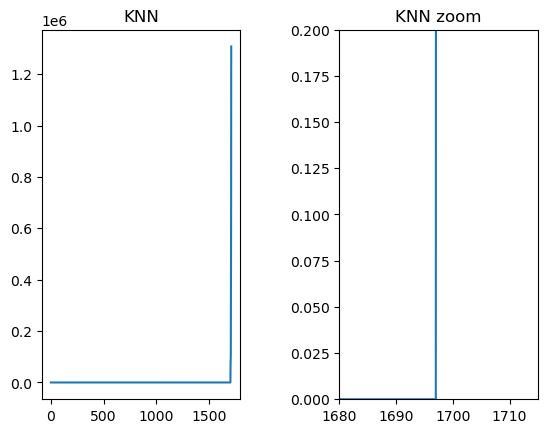

In [85]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(erp_distances)
distances, indices = neighbors_fit.kneighbors(erp_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([1680, 1715, 0, 0.2])

In [89]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd
from itertools import product
import numpy as np

results = []
eps_values = np.arange(0.001, 0.02, 0.001)
min_samples_values = np.arange(1, 5)
for eps, min_samples in product(eps_values, min_samples_values):
  # Ajusta el modelo HDBSCAN utilizando la matriz de distancias
  clusterer = DBSCAN(metric='precomputed', min_samples=min_samples, eps=eps)
  clusterer.fit(erp_distances)

  # Obtiene las etiquetas de los clusters para cada trayectoria
  labels = clusterer.labels_
  results.append([eps, min_samples, labels])

table = []
for eps, min_samples, labels in results:
  n_outliers = np.sum(labels == -1)
  table.append({
    "min_samples": min_samples,
    "eps": eps,
    "clusters": len(set(labels)),
    "outliers": n_outliers,
    "noise": 100 * n_outliers / len(labels),
    "silhouette": silhouette_score(erp_distances, labels)
  })

print(pd.DataFrame(table).sort_values(by='silhouette', ascending=False).head(20))

    min_samples    eps  clusters  outliers     noise  silhouette
45            2  0.012        29        12  0.701754    0.986096
37            2  0.010        29        12  0.701754    0.986096
25            2  0.007        29        12  0.701754    0.986096
29            2  0.008        29        12  0.701754    0.986096
61            2  0.016        29        12  0.701754    0.986096
21            2  0.006        29        12  0.701754    0.986096
33            2  0.009        29        12  0.701754    0.986096
53            2  0.014        29        12  0.701754    0.986096
17            2  0.005        29        12  0.701754    0.986096
65            2  0.017        29        12  0.701754    0.986096
57            2  0.015        29        12  0.701754    0.986096
13            2  0.004        29        12  0.701754    0.986096
1             2  0.001        29        12  0.701754    0.986096
69            2  0.018        29        12  0.701754    0.986096
9             2  0.003   

In [87]:
from sklearn.cluster import DBSCAN
import folium

# Run the grid search
clusterer = DBSCAN(metric='precomputed', min_samples=2, eps=0.012)
clusterer.fit(erp_distances)
labels = clusterer.labels_

m = folium.Map(location=trajectories[0][0], zoom_start=3, tiles='cartodbpositron', zoom_control=False)

# Add the trajectories to the map
for i, trajectory in enumerate(trajectories):
    # Choose a color based on whether the trajectory is anomalous
    color = 'red' if labels[i] == -1 else 'blue'
    # Set the line weight and opacity
    weight = 2 if labels[i] == -1 else 1
    opacity = 1 if labels[i] == -1 else 1
    folium.PolyLine(trajectory, color=color, weight=weight, opacity=opacity).add_to(m)

# Display the maps
m

### HDBSCAN

In [110]:
from sklearn.metrics import silhouette_score
import hdbscan

"""
Lo ideal es obtener el mayor coef. de silueta con el menor ruido posible. 
Segun Andrew Churchill and Michael Bloem, Hierarchical clustering of aircraft 
surface trajectories, AIAA AVIATION 2020 FORUM., los niveles de ruido no 
deberían superar el 20% y como mínimo, el nivel coef de silueta no debería bajar
de 50%
"""

erp_results = []
min_samples_values = np.arange(1, 16)
min_cluster_size_values = [2, 5, 10, 20, 40, 60, 80, 100, 120, 140]
for min_samples, min_cluster_size in product(min_samples_values, min_cluster_size_values):
  # Ajusta el modelo HDBSCAN utilizando la matriz de distancias
  clusterer = hdbscan.HDBSCAN(metric='precomputed', min_samples=min_samples, min_cluster_size = min_cluster_size)
  clusterer.fit(erp_distances)

  # Obtiene las etiquetas de los clusters para cada trayectoria
  labels = clusterer.labels_
  erp_results.append([min_samples, min_cluster_size, labels])

table = []
for min_samples, min_cluster_size, labels in erp_results:
  n_outliers = np.sum(labels == -1)
  table.append({
    "min_samples": min_samples,
    "min_clusters_size": min_cluster_size,
    "clusters": len(set(labels)),
    "outliers": n_outliers,
    "noise": 100 * n_outliers / len(labels),
    "silhouette": silhouette_score(erp_distances, labels)
  })

print(pd.DataFrame(table).sort_values(by='silhouette', ascending=False).head(20))

     min_samples  min_clusters_size  clusters  outliers     noise  silhouette
0              1                  2        30         6  0.350877    0.991603
20             3                  2        27         7  0.409357    0.990734
10             2                  2        27        10  0.584795    0.987600
11             2                  5        21        14  0.818713    0.982197
1              1                  5        21        14  0.818713    0.982197
31             4                  5        21        14  0.818713    0.982197
21             3                  5        21        14  0.818713    0.982197
30             4                  2        26        16  0.935673    0.979163
95            10                 60        10        19  1.111111    0.977522
85             9                 60        10        19  1.111111    0.977522
105           11                 60        10        19  1.111111    0.977522
145           15                 60        10        19  1.11111

In [111]:
import hdbscan
import folium

# Run the grid search
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_samples=1, min_cluster_size = 2)
clusterer.fit(erp_distances)
labels = clusterer.labels_

m = folium.Map(location=trajectories[0][0], zoom_start=3, tiles='cartodbpositron', zoom_control=False)

# Add the trajectories to the map
for i, trajectory in enumerate(trajectories):
    # Choose a color based on whether the trajectory is anomalous
    color = 'red' if labels[i] == -1 else 'blue'
    # Set the line weight and opacity
    weight = 2 if labels[i] == -1 else 1
    opacity = 1 if labels[i] == -1 else 1
    folium.PolyLine(trajectory, color=color, weight=weight, opacity=opacity).add_to(m)

# Display the maps
m